# 🧼 Clean an existing preference dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/argilla-io/distilabel/blob/main/docs/tutorials/clean-preference-dataset-judgelm-gpt.ipynb) [![Open Source in Github](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/argilla-io/distilabel/blob/main/docs/tutorials/clean-preference-dataset-judgelm-gpt.ipynb)

In this tutorial, we will explain how to use `distilabel` to clean the known DPO dataset [orca_dpo_pairs](https://huggingface.co/datasets/Intel/orca_dpo_pairs). If you want a spoiler, you can check the [cleaned dataset](https://huggingface.co/datasets/argilla/distilabel-intel-orca-dpo-pairs).

We will follow the next steps:

* Prepare the original dataset for cleaning.
* Create and run the **distilabel pipeline**.
* Optionally, post-process the cleaned dataset.
* Analyze the **distilabelled dataset**.

## Introduction

Many open-source datasets are highly used to train and evaluate NLP models. However, many can be still improved in terms of quality, as we did with [UltraFeedback](https://huggingface.co/datasets/argilla/ultrafeedback-curated), [Dollys](https://huggingface.co/datasets/argilla/databricks-dolly-15k-curated-en) or [Alpacas](https://huggingface.co/datasets/argilla/alpaca_data_cleaned). 

In this case, the main intuition was that the original dataset just assumes gpt4/3.5-turbo is always the best response, but that's not always the case. And DPO fine-tuning benefits from the diversity of preference pairs.

To address this issue, we used `distilabel`, an AI Feedback (AIF) framework that can generate and label datasets using LLMs and can be used for many different use cases.

## Getting Started

### Install Dependencies

Let’s start by installing the required dependencies to run **distilabel** and the remainder of this tutorial. Install **Argilla** for a better visualization and curation of the results

In [ ]:
%pip install -q -U "distilabel[openai,argilla]" --upgrade

Then we can import the required libraries.

In [ ]:
import os
import random

import nltk
import numpy as np
import openai
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from datasets import load_dataset
from distilabel.llm import OpenAILLM
from distilabel.pipeline import Pipeline
from distilabel.tasks import JudgeLMTask
nltk.download('punkt')

### Environment variables

Finally, we will also need to provide an HF_TOKEN and the OPENAI_API_KEY to run the distilabel pipeline.

In [ ]:
# HF Token
os.environ['HF_TOKEN'] = "hf_..."

# OpenAI API Key
os.environ["OPENAI_API_KEY"] = 'sk-...'
openai.api_key = os.environ["OPENAI_API_KEY"]

## Prepare the Dataset

First, we will load the original [orca_dpo_pairs](https://huggingface.co/datasets/Intel/orca_dpo_pairs), which consists of 12,859 preference pairs.

> Note: To enhance performance while using this tutorial as a guide, consider selecting a subset of samples from the original dataset.
```python
subsample = dataset.select(range(500))
```

In [ ]:
# Load the dataset
dataset = load_dataset("Intel/orca_dpo_pairs", split="train")

In [ ]:
dataset

Dataset({
    features: ['system', 'question', 'chosen', 'rejected'],
    num_rows: 12859
})

In order to avoid positional bias and keep track of the order we will create and apply the function `shuffle_and_track` to the dataset. This function takes **chosen** and **rejected**, shuffles them randomly, and then returns a dictionary that includes the shuffled pair as **generations** and the **order** in which they were shuffled based on their original identification.

In [ ]:
# Shuffle 'chosen' and 'rejected'
def shuffle_and_track(chosen, rejected):
    pair = [chosen, rejected]
    random.shuffle(pair)
    order = ["chosen" if x == chosen else "rejected" for x in pair]
    return {"generations": pair, "order": order}

# Apply the function to the dataset
dataset = dataset.map(lambda x: shuffle_and_track(x["chosen"], x["rejected"]))

Moreover, to indicate which will be the input to be used for generation in our pipeline, we will rename the **question** column to **input**. This dataset is already binarized, but if you don't know about binarization or do you want to know how to binarize a dataset, you can take a look at [here](https://distilabel.argilla.io/latest/technical-reference/pipeline/).

In [ ]:
# Rename the column
dataset = dataset.rename_columns({"question": "input"})

In [ ]:
dataset

Dataset({
    features: ['system', 'input', 'chosen', 'rejected', 'generations', 'order'],
    num_rows: 12859
})

## Create the Pipeline

In this case, we will only need to include a `labeller` in our pipeline. The labeller will rate the generations according to the input and will add the rationale behind its score. So, we will start by initializing it using the OpenAI integration, which will take the following [arguments](https://distilabel.argilla.io/latest/reference/distilabel/llm/openai/#distilabel.llm.openai.OpenAILLM):

- `task`: Specify the usage of the LLM as a labeller by creating a prompt using a standard template. The [JudgeLMTask](https://distilabel.argilla.io/latest/reference/distilabel/tasks/preference/judgelm/#distilabel.tasks.preference.judgelm.JudgeLMTask) is designed to evaluate the performance of AI assistants.
- `model`: We use `gpt-4-1106-preview` as the model to be used for generation.
- `num_threads`: `16` of threads to be used for parallel generation.
- `max_new_tokns`: `512` is the maximum number of tokens to be generated.

> For more information about the [LLM integrations](https://distilabel.argilla.io/latest/technical-reference/llms/), [tasks](https://distilabel.argilla.io/latest/technical-reference/tasks/) and different components of the [pipeline](https://distilabel.argilla.io/latest/technical-reference/pipeline/), please check the documentation.

In [ ]:
# Initialize the labeller
labeller = OpenAILLM(
    task=JudgeLMTask(),
    model="gpt-4-1106-preview",
    num_threads=16,
    max_new_tokens=512,
)

Then, we will add the labeller to the pipeline. We can check that no generator was added and the labeller takes the arguments we specified before.

In [ ]:
# Create the pipeline
distipipe = Pipeline(
    labeller=labeller
)
distipipe

Pipeline(
	generator=None,
	labeller=OpenAILLM(task=JudgeLMTask, num_threads=16, promp_format='None', model='gpt-4-1106-preview')
)

Finally, we will run the pipeline using the `generate` method. This method will take the input dataset and the desired number of generations to be performed for each input. For our case, we will indicate 2, one to rate *chosen* and the other for *rejected* that were added to the  **generations** column.

> Remember that the labeling process can take a while depending on the number of generations and the number of threads specified.

In [ ]:
# Compute ratings and natural language critiques for each pair
disti_dataset = distipipe.generate(dataset=dataset, num_generations=2)

Now, we can inspect the dataset again, as the generations and the rationale behind the score were added to the original dataset as *rating* and *rationale*.

In [ ]:
disti_dataset.select_columns(["input", "generations", "rating", "rationale"])[0]

## Human Feedback with Argilla

You can use the AI Feedback created by distilabel directly but we have seen that enhancing it with human feedback will improve the quality of your LLM. We provide a `to_argilla` method which creates a dataset for Argilla along with out-of-the-box tailored metadata filters and semantic search to allow you to provide human feedback as quickly and engaging as possible. You can check [the Argilla docs](https://docs.argilla.io/en/latest/getting_started/quickstart_installation.html) to get it up and running.

First, install it.

In [ ]:
!pip install "distilabel[argilla]"

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the URL and API_KEY:

In [ ]:
import argilla as rg

# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="http://localhost:6900",
    api_key="owner.apikey",
    workspace="admin"
)

You can now push the dataset to Argilla as follows and start annotating it:

In [ ]:
# Convert the dataset to Argilla format adding questions and metadata
rg_dataset = disti_dataset.to_argilla()

# Push the dataset to Argilla
rg_dataset.push_to_argilla(name="your_dataset_name", workspace="admin")

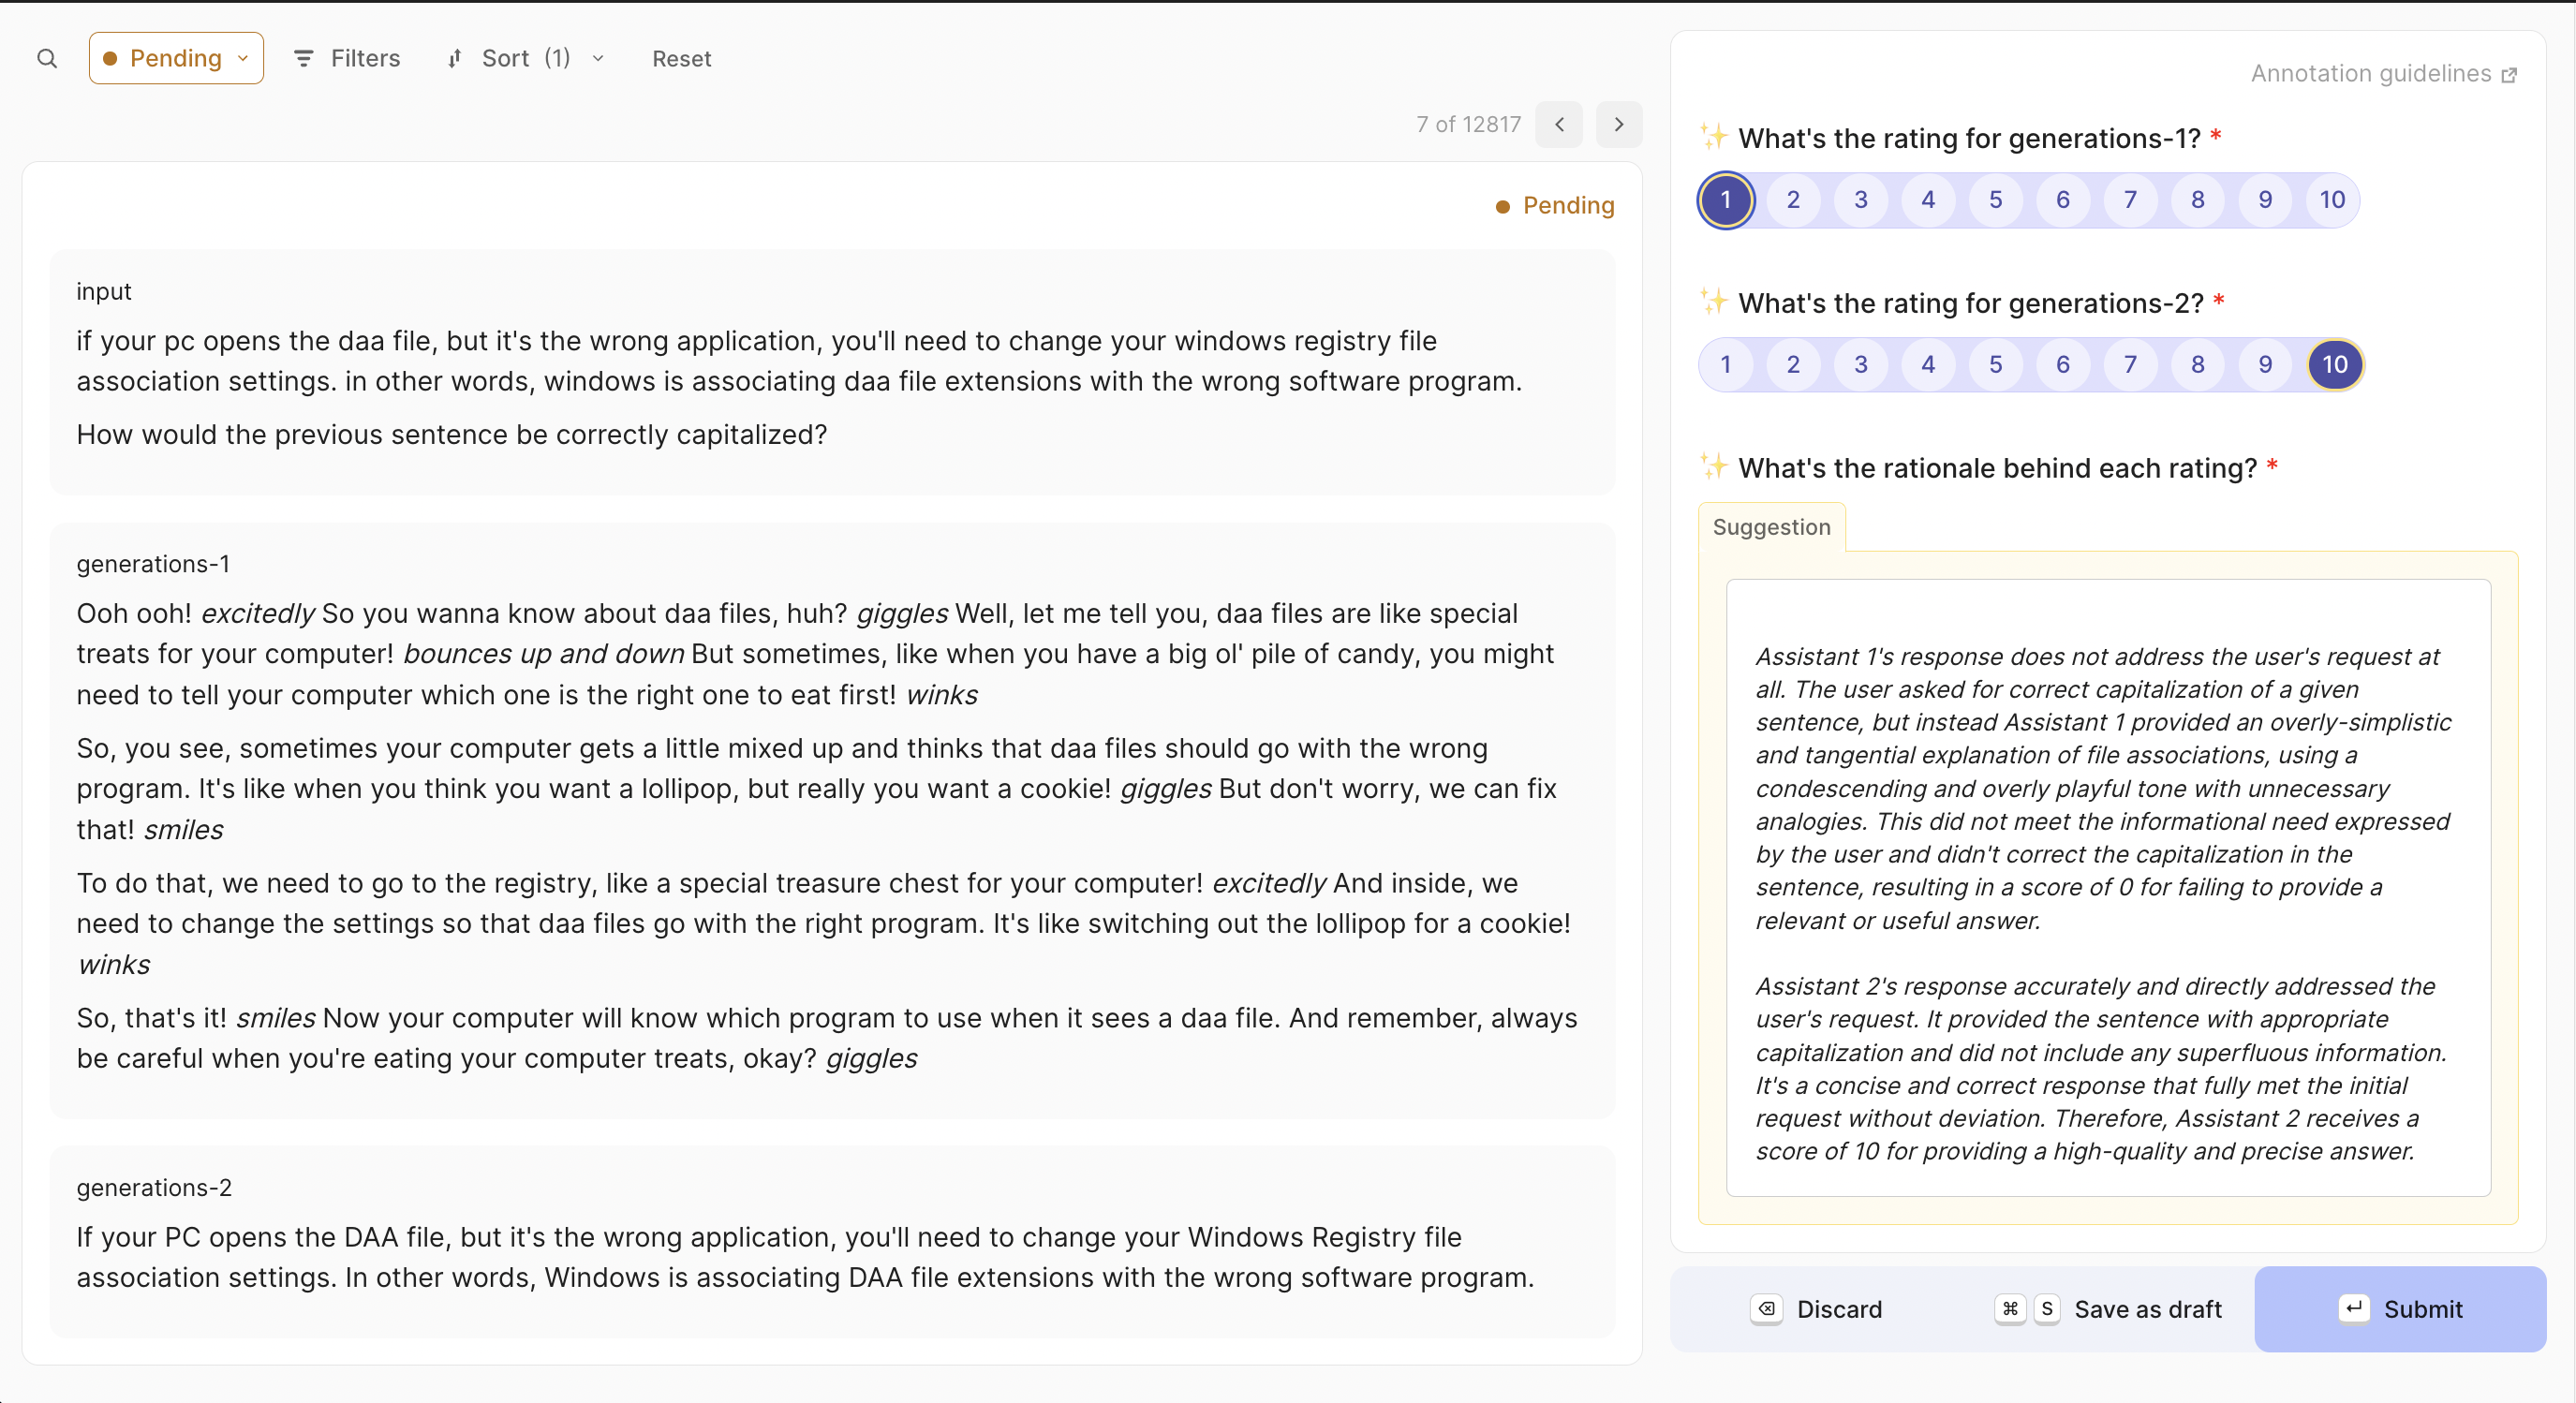

### Optional: Post-process the dataset

Even if the dataset was already curated, we can still improve it by adding more information. Thus, we will swap rejected and chosen, and add chosen scores and status.

The `add_status` function assesses the status of a set of responses based on their ratings and order. If there are no ratings, or if both ratings are equal, it sets the status to **tie**. If that's not the case, but the highest-rated response is not the *chosen* one, then is **swapped**. Otherwise, it keeps the status as **unchanged**.

The `swap` function returns a dictionary with the current and original *chosen* and *rejected* items and the score of the chosen item.

In [ ]:
# Define the add_status function
def add_status(r):
  status = "unchanged"
  highest_rated_idx = np.argmax(r['rating'])
  if r['rating']== None or r['rating'][0] == r['rating'][1]:
    status = "tie"
  elif r['order'][highest_rated_idx] != 'chosen':
      status = "swapped"
  return {"status": status}

# Define the swap function
def swap(r):
  chosen = r["chosen"]
  rejected = r["rejected"]
  if r['rating'] is not None:
    chosen_score = r['rating'][np.argmax(r['rating'])]
  else:
    chosen_score = None
  if r['status'] == "swapped":
    chosen = r["rejected"]
    rejected = r["chosen"]
  return {
      "chosen": chosen,
      "rejected": rejected,
      "original_chosen": r["chosen"],
      "original_rejected": r["rejected"],
      "chosen_score": chosen_score
  }

# Apply the functions to the dataset
updated_disti_dataset = disti_dataset.map(add_status).map(swap)

In [ ]:
updated_disti_dataset[0]

### Optional: Find duplicated examples

Conversely, when training a model to ensure the accuracy of its results, it is essential to verify that your training samples are not duplicated in your test set. In our case, we will use our dataset as an example and compare it with the [gsm8k](https://huggingface.co/datasets/gsm8k) test dataset, which comprises 7473 samples in each subset.

In [ ]:
# Load the source dataset
source_dataset = load_dataset("gsm8k", "main", split="train")
source_dataset_socratic = load_dataset("gsm8k", "socratic", split="train")

# Load the target dataset
target_dataset = load_dataset("argilla/distilabel-intel-orca-dpo-pairs", split="train")

Then, we will extract the questions from both datasets and preprocess them tokenizing and lowercasing them.

In [ ]:
# Extract the 'question' column from each dataset
source_questions = source_dataset['question']
source_questions_socratic = source_dataset_socratic['question']
target_questions = target_dataset['input']

In [ ]:
# Function to preprocess the text
def preprocess(text):
    return nltk.word_tokenize(text.lower())

# Preprocess the questions
source_questions_processed = [preprocess(q) for q in source_questions]
source_questions.extend([preprocess(q) for q in source_questions_socratic])
target_questions_processed = [preprocess(q) for q in target_questions]

Finally, we will compare the questions from the test set with the ones from our dataset and check if there are any duplicated samples. To do so, we will vectorize the questions and calculate the cosine similarity. The threshold set was 0.8 so that we could avoid false positives, as it was tested manually.

In [ ]:
# Vectorize the questions
vectorizer = TfidfVectorizer()
source_vec = vectorizer.fit_transform([' '.join(q) for q in source_questions_processed])
target_vec = vectorizer.transform([' '.join(q) for q in target_questions_processed])

In [ ]:
# Calculate cosine similarity
similarity_matrix = cosine_similarity(source_vec, target_vec)

In [ ]:
# Determine matches based on a threshold
threshold = 0.8
matching_pairs = []
for i, row in enumerate(similarity_matrix):
    for j, similarity in enumerate(row):
        if similarity >= threshold:
            matching_pairs.append((source_questions[i], target_questions[j], similarity))

We can inspect the results by creating a dataframe.

In [ ]:
# Create a DataFrame from the matching pairs
similarity_df = pd.DataFrame(matching_pairs, columns=['Source Question', 'Target Question', 'Similarity Score'])

In [ ]:
similarity_df.head()

,Source Question,Target Question,Similarity Score
0,Hans booked a room in a hotel. The hotel has 1...,Lizzy: Hans booked a room in a hotel. The hote...,0.822757
1,John orders food for a massive restaurant. He...,John orders food for a massive restaurant. He ...,0.884102
2,Ariella has $200 more in her son's saving acco...,Lizzy: Ariella has $200 more in her son's savi...,0.831908
3,Mike and Ted planted tomatoes. In the morning...,"Mike and Ted planted tomatoes. In the morning,...",0.971729
4,A washing machine uses 20 gallons of water for...,Question: A washing machine uses 20 gallons of...,0.961750


And, we can add a new column to our dataset indicating whether each question is matched.

In [ ]:
# Create a set of matching target questions
matching_target_questions = list(similarity_df['Target Question'])

# Add a column to the target dataset indicating whether each question is matched
target_dataset = target_dataset.map(lambda example: {"in_gsm8k_train": example['input'] in matching_target_questions})
target_dataset

Dataset({
    features: ['system', 'input', 'chosen', 'rejected', 'generations', 'order', 'labelling_model', 'labelling_prompt', 'raw_labelling_response', 'rating', 'rationale', 'status', 'original_chosen', 'original_rejected', 'chosen_score', 'in_gsm8k_train'],
    num_rows: 12859
})

## Analyze our cleaned dataset

This dataset is great for fine-tuning preferences, and it's a better choice than the original one. It's set up in the easy-to-understand "chosen, rejected" format and comes with extra details for more experiments and filtering. This updated dataset is really handy because it shows which responses are favorites (according to gpt-4-turbo), points out the responses with low scores, and even includes explanations in everyday language.

The main changes are:

* ~2K pairs have been swapped: rejected becomes the chosen response. We have kept the original chosen and rejected on two new columns original_* for reproducibility purposes.
* 4K pairs have been identified as tie: equally bad or good.
* Chosen scores have been added: you can now filter out based on a threshold (see our distilabeled Hermes 2.5 model for an example)
* We have kept the ratings and rationales generated with gpt-4-turbo and distilabel so you can prepare the data differently if you want.
* We have added a column to indicate if the input is part of gsm8k train set.

This results in 5,922 instead of 12,859 samples (54% reduction) and leads to better performance than the same model tuned with 100% of the samples in the original dataset.

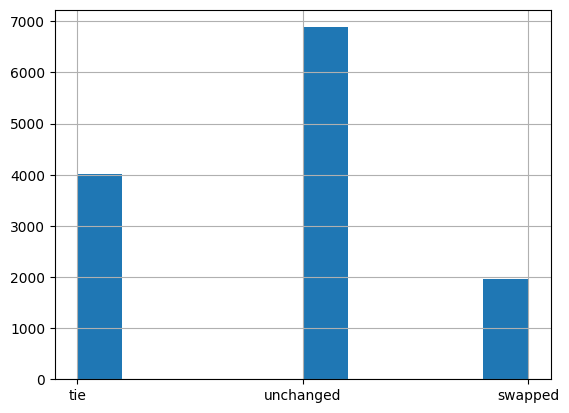

In [2]:
# Check the distilabelled dataset
dataset = load_dataset("argilla/distilabel-intel-orca-dpo-pairs", split="train")

# Filter out the unchanged and tied examples
dataset = dataset.filter(
    lambda r: 
        r["status"] != "tie" and 
        r["chosen_score"] >= 8 and 
        not r["in_gsm8k_train"]
)
dataset

Dataset({
    features: ['system', 'input', 'chosen', 'rejected', 'generations', 'order', 'labelling_model', 'labelling_prompt', 'raw_labelling_response', 'rating', 'rationale', 'status', 'original_chosen', 'original_rejected', 'chosen_score', 'in_gsm8k_train'],
    num_rows: 5922
})

## Conclusions

In summary, we've demonstrated the process of cleaning a preference dataset using `distilabel`. Additionally, we've illustrated how to employ Argilla for visualizing and annotating the dataset that has been cleaned with distilabel. Lastly, we've covered the steps for post-processing the dataset and provided an analysis of the key changes that were made.

Now the next question is: can we build better models with this new knowledge? The answer is the [distilabeled Hermes](https://huggingface.co/argilla/distilabeled-Hermes-2.5-Mistral-7B) model, check it out!

Have a look at these resources if you want to go further:

- [Train a Model with ArgillaTrainer](https://docs.argilla.io/en/latest/tutorials_and_integrations/tutorials/feedback/end2end_examples/train-model-006.html)
- [Use Notus on inference endpoints to create a legal preference dataset](https://distilabel.argilla.io/latest/tutorials/pipeline-notus-instructions-preference-legal.html)